# LD workflow

This workflow generate the LD matrixs base on the genotype for each gene and saved in both RDS and text format

**FIXME: we may compute it with SuSiE and not use this pipeline. It will be removed once the SuSiE based pipeline is done**

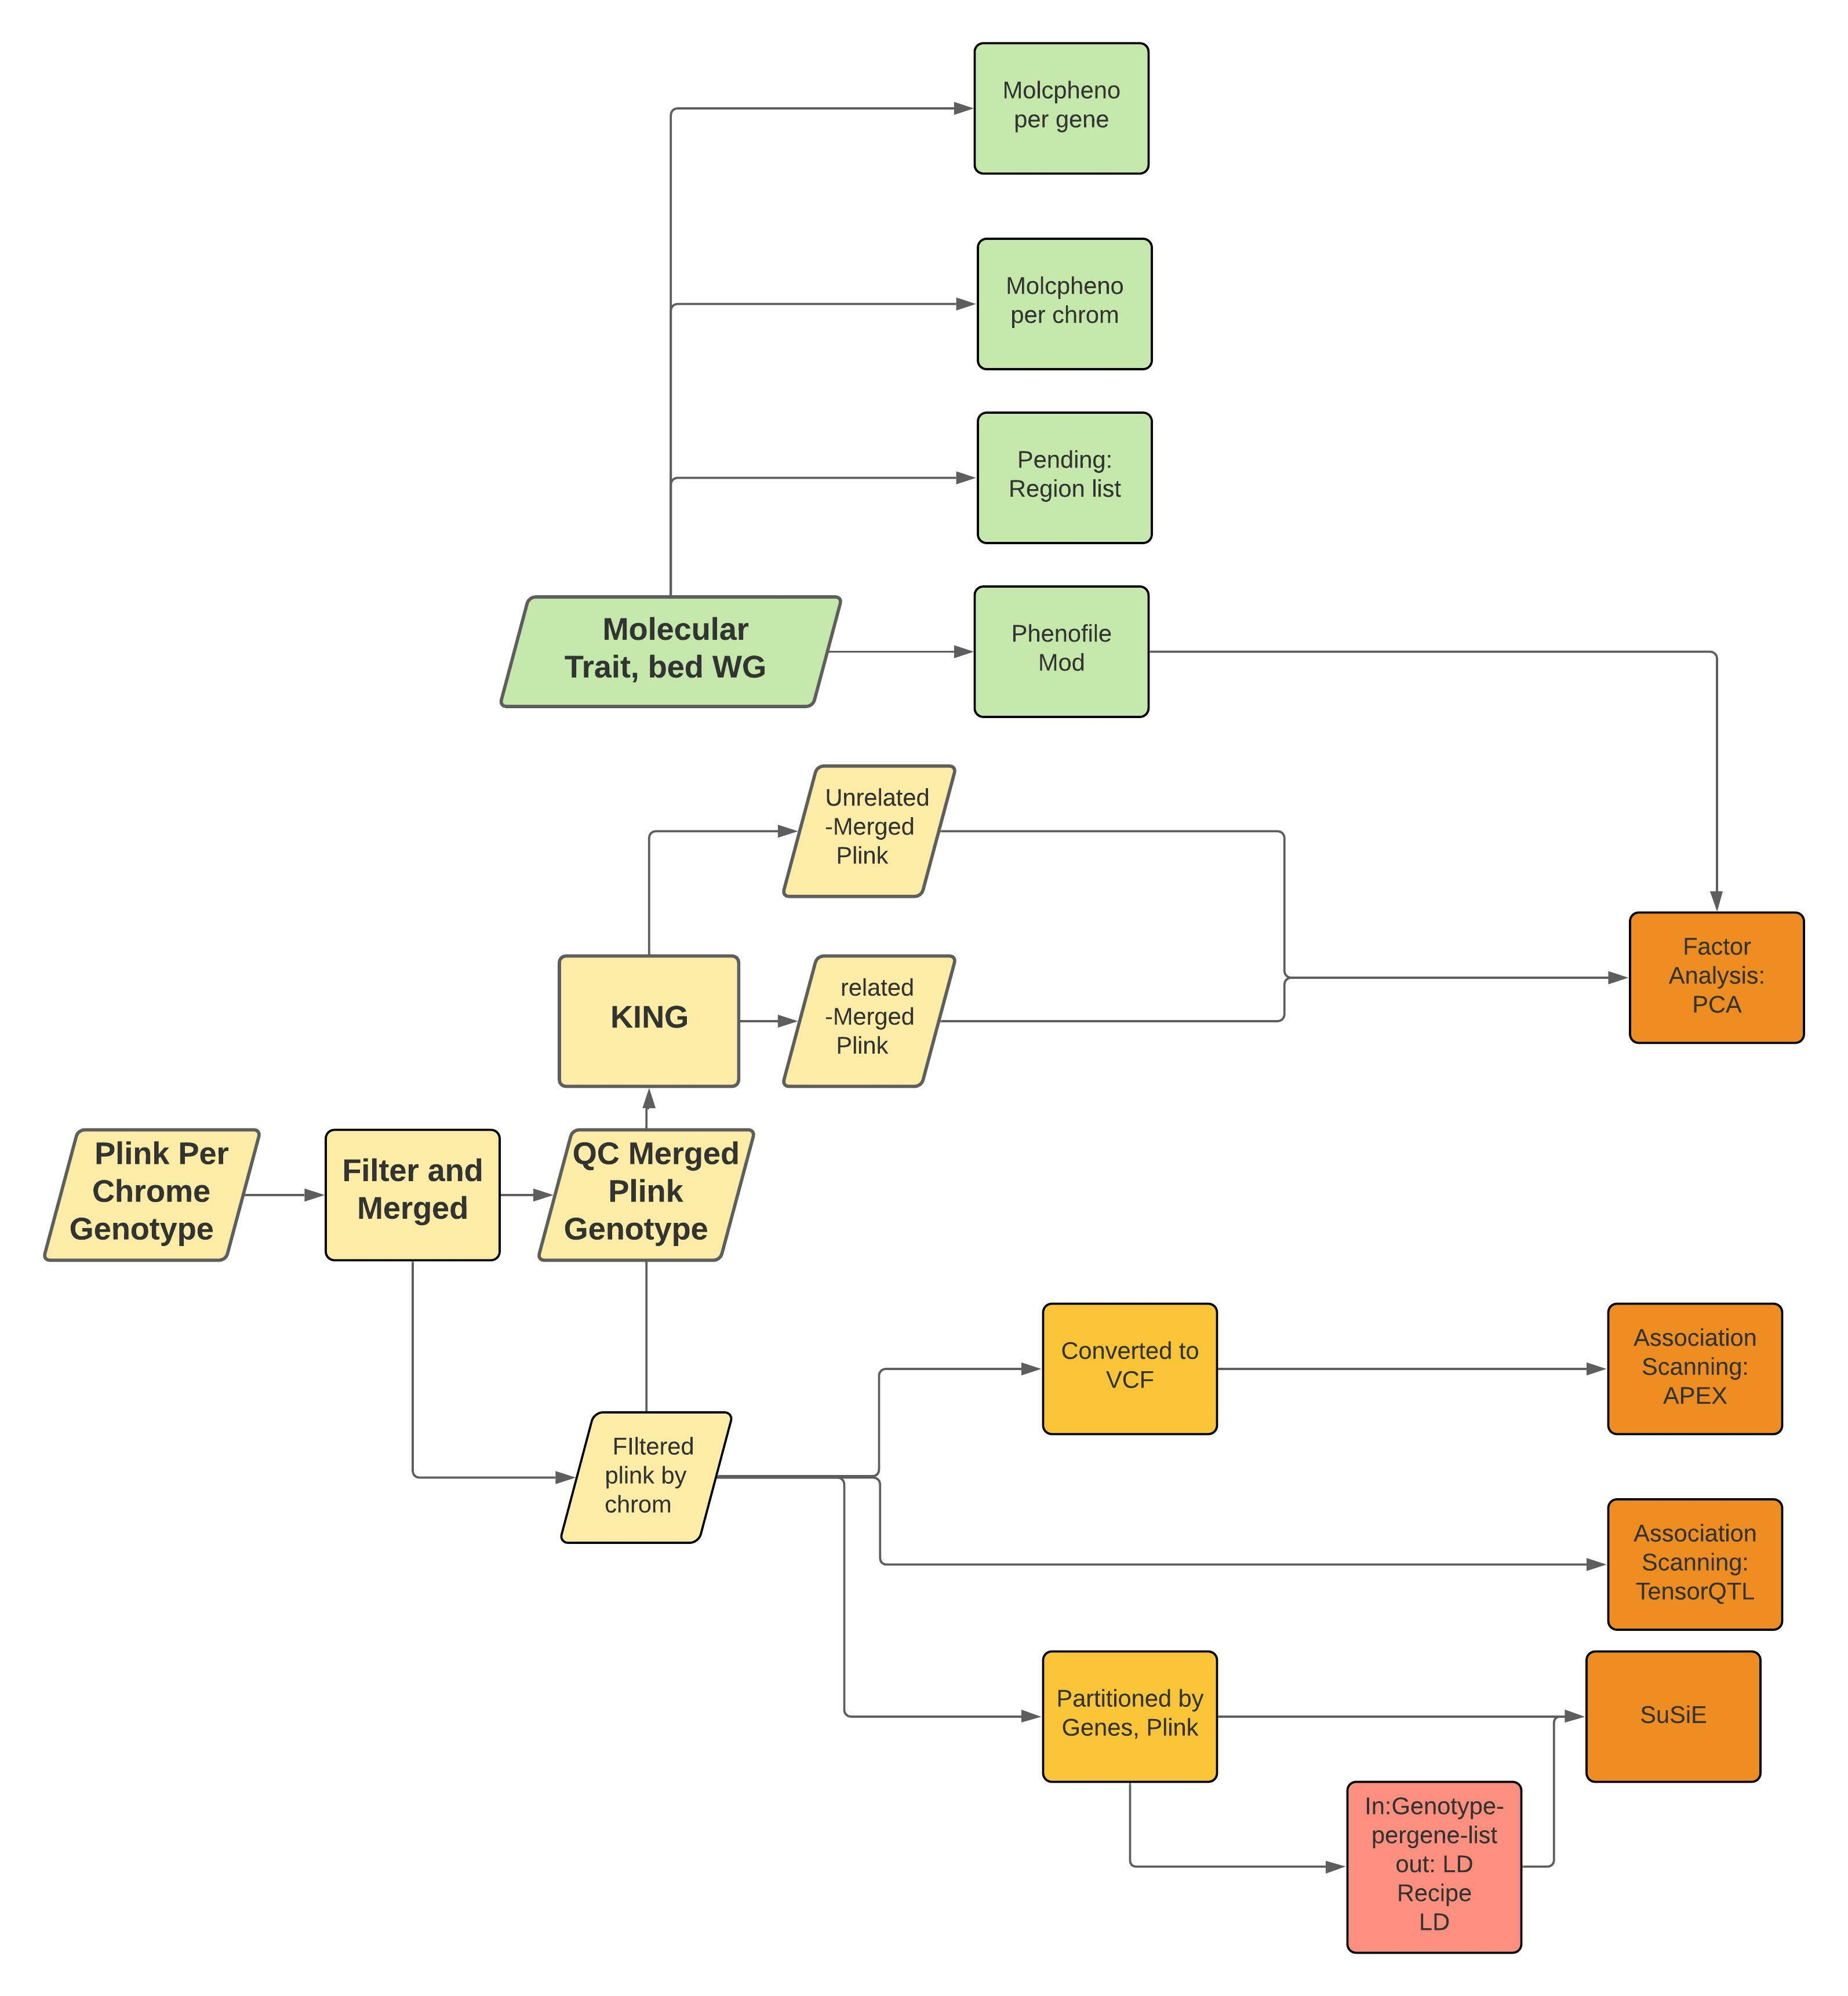

## LD computation for each gene
This workflow takes in list of per gene plink trio and compute LD for them, one row of LD recipe will be generated to be merged later on

In [ ]:
[global]
# the output directory for generated files
parameter: wd = path
cwd = wd
# A string to identify your analysis run
parameter: name = f"{cwd:b}"
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Wall clock time expected
parameter: walltime = "5h"
# Memory expected
parameter: mem = "16G"
# Number of threads
parameter: numThreads = 20
# Software container option
parameter: container = 'statisticalgenetics/lmm:2.4'
# use this function to edit memory string for PLINK input
from sos.utils import expand_size
cwd = f"{cwd:a}"
import pandas as pd
parameter: genotype_list = path
geno_file_inv = pd.read_csv(genotype_list, sep = "\t")
genoFile = geno_file_inv["dir"].values.tolist()

In [2]:
# Filter SNPs and select individuals 
[LD_1]
# Window size
parameter: window = 50
# Shift window every 10 snps
parameter: shift = 10
parameter: r2 = 0.1

input: genoFile, group_by = 1 
output: f'{cwd}/{name}_ld/{_input:bn}.ld',
        ld_rds = f'{cwd}/{name}_ld/{_input:bn}.ld.rds'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash:  expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout',container = container
    plink \
    --bfile ${_input:n} \
    --indep-pairwise ${window} ${shift} ${r2}  \
    --out ${_output[0]:n} \
    --threads ${numThreads} \
    --memory ${int(expand_size(mem) * 0.9)/1e6} \
    --r square \
    --allow-no-sex

R: expand = '${ }', stdout = f"{_output[0]:n}.stdout", stderr = f"{_output[0]:n}.stderr", container = container
    name = read.table("${_input:n}.bim",sep = "\t")$V2
    ld = as.matrix(data.table::fread("${_output[0]}"))
    rownames(ld) <- colnames(ld) <- name
    saveRDS(ld, "${_output[1]}")
  

In [ ]:
[LD_2]
import pandas as pd
input: group_by = "all"
output: f'{cwd}/{name}_LD_recipe'
df = pd.DataFrame({
"Theme" : name,
"ld_file_prefix" : f'{cwd}/{name}_ld/',
"ld_file_surfix" : ".ld.rds"
},index = [0])

df.to_csv(_output,sep = "\t",index = 0)